In [71]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from scipy.interpolate import UnivariateSpline

In [173]:
ind="stashcp-2016.6"

myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*a2gb*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1466622721000,
                  "lte": 1466674003000,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}


# Create total results list from es scroll

In [12]:
page= es.search(index=ind, body=myquery1, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

1640


# Create dataframe from results

In [13]:
df = pd.DataFrame(Res)

del df['destination_space']
del df['xrdcp_version']
del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(df.head(2))
print(list(df.columns.values))

  download_time                         filename                        host  \
0        195689  user/taburaad/public/a2gb_1.tar  root://data.ci-connect.net   
1        213298  user/taburaad/public/a2gb_1.tar  root://data.ci-connect.net   

   sitename         status      timestamp          begin  
0  SU-OG-CE  Trunk Success  1466622721000  1466622525311  
1  SU-OG-CE  Trunk Success  1466622996000  1466622782702  
['download_time', 'filename', 'host', 'sitename', 'status', 'timestamp', 'begin']


In [14]:
df_UCSDT2=pd.DataFrame(columns=['download_time','filename','host','sitename','status','timestamp'])
for i in range(scroll_size):
    if df.iloc[i,3]=='UCSDT2-C':
        df_UCSDT2=df_UCSDT2.append(df.iloc[[i]])
        
df_UCSDT2=df_UCSDT2.sort_values(by=['timestamp'])
df_UCSDT2['try']=0
f=0
s=0
i=0
length=df_UCSDT2.shape[0]
#print(df_UCSDT2.head(10))    
while i<200:
    df_UCSDT2.iloc[i,6]=1
    df_UCSDT2.iloc[i+1,6]=2
    f+=int(df_UCSDT2.iloc[i,0])
    s+=int(df_UCSDT2.iloc[i+1,0])
    i=i+2
    
#second / first try = speed-up
UCSDT2_speedup=(s/f)
print(UCSDT2_speedup)

1.0000002012311404


In [15]:
def speed_up(sitename):
    columns=list(df.columns.values)
    df_site=pd.DataFrame(columns=columns)
    for i in range(scroll_size):
        if df['sitename'][i]==sitename:
            df_site=df_site.append(df.iloc[[i]])
            
    df_site=df_site.sort_values(by=['timestamp'])
    df_site['try']=0
    #print (df_site['host'].iloc[1])
    f=0
    s=0
    i=0
    length=df_site.shape[0]
    #print (length)
    if (length%2==1):
        df_site=df_site[:length-1]
    length=df_site.shape[0]
    host=df_site['host'].iloc[1]
    #print (length)
    #print(df_site.head(100))
    while i<length:
        df_site['try'][i]=1
        df_site['try'][i+1]=2
        f+=int(df_site['download_time'].iloc[i])
        s+=int(df_site['download_time'].iloc[i+1])
        i+=2

    #second / first try = speed-up
    speedup=(s/f)
    avg1=(f/length)/1000
    avg2=(s/length)/1000
    print("- speed up: %.2f, avg first try: %.2f sec, avg second try: %.2f sec using host %s" % (speedup, avg1, avg2, host))

speed_up('UFlorida-HPC')

- speed up: 0.99, avg first try: 40.15 sec, avg second try: 39.76 sec using host root://data.ci-connect.net


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
print("UCSDT2-C:")
speed_up('UCSDT2-C')
print("BNL_ATLAS_1:")
speed_up('BNL_ATLAS_1')
print("UFlorida-HPC:")
speed_up('UFlorida-HPC')
print("UNL (red-gateway2):")
speed_up('red-gateway2')
print("MWT2_CE_UIUC:")
speed_up('MWT2_CE_UIUC')
print("UNC: (Sandhills-CE1):")
speed_up('Sandhills-CE1')
print("SU-OG-CE:")
speed_up('SU-OG-CE')

UCSDT2-C:


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


- speed up: 0.08, avg first try: 146.30 sec, avg second try: 11.53 sec using host root://xrd-cache-1.t2.ucsd.edu
BNL_ATLAS_1:
- speed up: 0.95, avg first try: 55.16 sec, avg second try: 52.68 sec using host root://data.ci-connect.net
UFlorida-HPC:
- speed up: 0.99, avg first try: 40.15 sec, avg second try: 39.76 sec using host root://data.ci-connect.net
UNL (red-gateway2):
- speed up: 0.24, avg first try: 42.18 sec, avg second try: 10.27 sec using host root://hcc-stash.unl.edu
MWT2_CE_UIUC:
- speed up: 1.30, avg first try: 23.81 sec, avg second try: 30.99 sec using host root://data.ci-connect.net
UNC: (Sandhills-CE1):
- speed up: 0.38, avg first try: 23.83 sec, avg second try: 8.99 sec using host root://hcc-stash.unl.edu
SU-OG-CE:
- speed up: 0.99, avg first try: 102.83 sec, avg second try: 101.83 sec using host root://data.ci-connect.net


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [169]:
columns=list(df.columns.values)
df1=pd.DataFrame(columns=columns)
for i in range(scroll_size):
    if df['host'][i]=='root://xrd-cache-1.t2.ucsd.edu':
        df1=df1.append(df.iloc[[i]])
#print(df1.head(2))
length=df1.shape[0]
df1['trunk']=0
df1['timeout']=0
for i in range(length):
    begin=int(df1['begin'].iloc[i])//1000
    end=int(df1['timestamp'].iloc[i])//1000
    df1['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df1['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')
    if df1['status'].iloc[i]=='Trunk Success':
        df1['trunk'].iloc[i]=1
    if df1['status'].iloc[i]=='Timeout':
        df1['timeout'].iloc[i]=1 
    
df1=df1.set_index(['timestamp'])    
df1.index = pd.to_datetime(df1.index, unit='s')
print(df1.head(1))
    

/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                    download_time                         filename  \
timestamp                                                            
2016-06-22 14:33:04         20896  user/taburaad/public/a2gb_1.tar   

                                               host  sitename   status  \
timestamp                                                                
2016-06-22 14:33:04  root://xrd-cache-1.t2.ucsd.edu  UCSDT2-C  Success   

                                   begin  trunk  timeout  
timestamp                                                 
2016-06-22 14:33:04  2016-06-22 14:32:43      0        0  


In [172]:
print(len(df1))
print(pd.value_counts(df1['timeout'].values, sort=False))

198
0    198
dtype: int64


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


<class 'pandas.core.series.Series'>


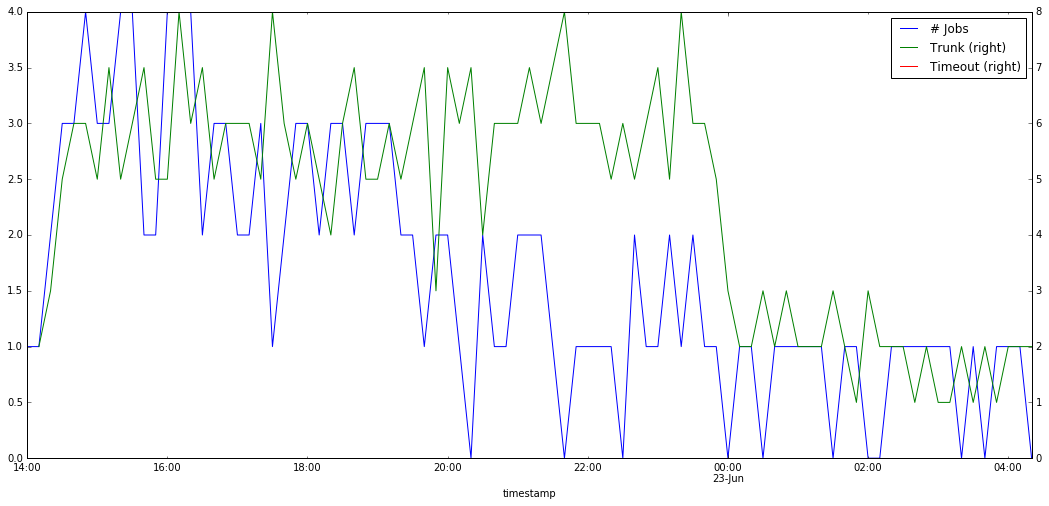

In [162]:
df1['begin']=pd.to_datetime(df1.begin, unit='s')
#df1['timestamp']=pd.to_datetime(df1.timestamp)

#print(df1.head(2))
jobs = pd.concat([pd.Series(1, df1.begin), pd.Series(-1, df1.index)]).resample('10Min', how='sum').cumsum()

trunk=df1.trunk.resample('10Min',how='sum')
timeout=df1.timeout.resample('10Min',how='sum')

plt.figure(figsize=[18, 8]) 
jobs.plot(label="# Jobs", legend=True)
trunk.plot(secondary_y=True, label="Trunk", legend=True)
timeout.plot(secondary_y=True, label="Timeout", legend=True)

plt.figure(figsize=[18, 8])
#plt.plot(jobs)
#plt.ylabel('# concurrent jobs')
#plt.show()




In [167]:
def plot_jobs(site):
    columns=list(df.columns.values)
    df_site=pd.DataFrame(columns=columns)
    for i in range(scroll_size):
        if df['host'][i]==site:
            df_site=df_site.append(df.iloc[[i]])
    length=df_site.shape[0]
    df_site['trunk']=0
    df_site['timeout']=0
    for i in range(length):
        begin=int(df_site['begin'].iloc[i])//1000
        end=int(df_site['timestamp'].iloc[i])//1000
        df_site['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
        df_site['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')
        if df_site['status'].iloc[i]=='Trunk Success':
            df_site['trunk'].iloc[i]=1
        if df_site['status'].iloc[i]=='Timeout':
            df_site['timeout'].iloc[i]=1 
    
    df_site=df_site.set_index(['timestamp'])    
    df_site.index = pd.to_datetime(df_site.index, unit='s')
    df_site['begin']=pd.to_datetime(df_site.begin, unit='s')

    jobs = pd.concat([pd.Series(1, df_site.begin), pd.Series(-1, df_site.index)]).resample('10Min', how='sum').cumsum()
    trunk=df_site.trunk.resample('10Min',how='sum')
    timeout=df_site.timeout.resample('10Min',how='sum')

    plt.figure(figsize=[18, 8]) 
    plt.title('Concurrent jobs vs. completion status of ' + site)
    jobs.plot(label="# Jobs", legend=True)
    trunk.plot(secondary_y=True, label="Trunk", legend=True)
    timeout.plot(secondary_y=True, label="Timeout", legend=True)


/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


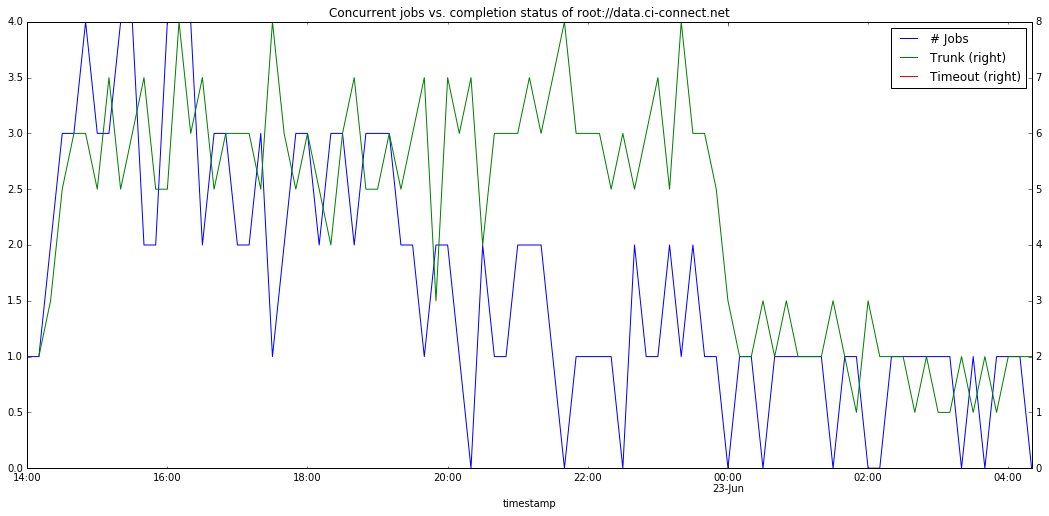

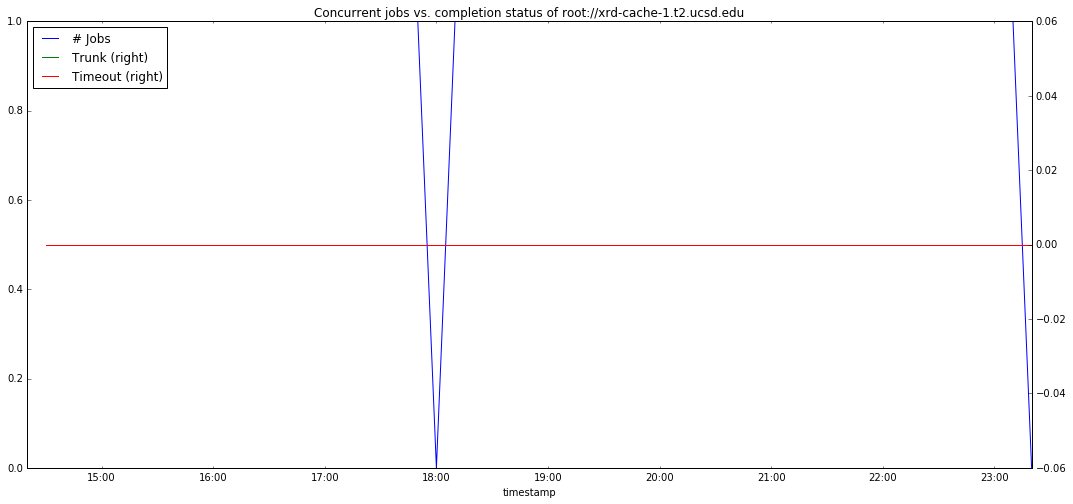

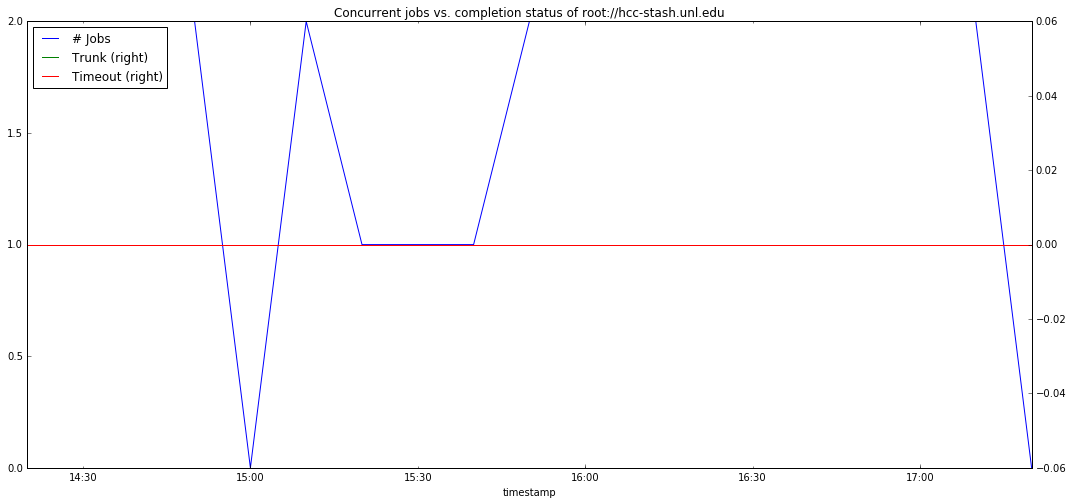

In [168]:
plot_jobs('root://data.ci-connect.net')
plot_jobs('root://xrd-cache-1.t2.ucsd.edu')
plot_jobs('root://hcc-stash.unl.edu')

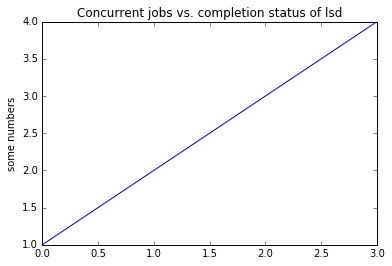

In [166]:
site='lsd'
plt.title('Concurrent jobs vs. completion status of ' + site)
plt.plot([1,2,3,4])
plt.ylabel('some numbers')
plt.show()